In [5]:
from pathlib import Path
import pandas as pd

wt_data = pd.read_csv(Path("generated", "WyckoffTransformer_mp_20_biternary_relaxed.zip"), index_col=0)

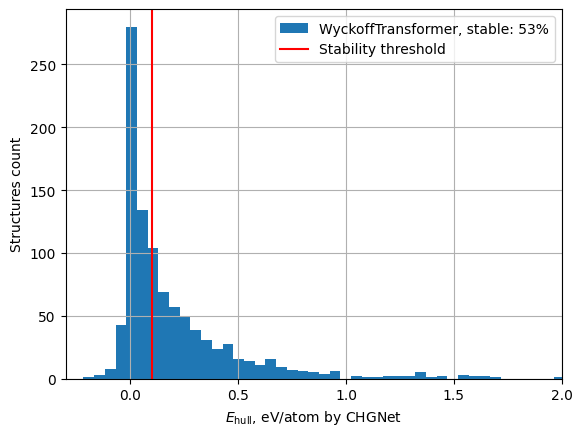

In [39]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
wt_data.corrected_chgnet_ehull.hist(bins=200, ax=ax,
    label=f"WyckoffTransformer, stable: {100*(wt_data.corrected_chgnet_ehull < 0.1).sum()/len(wt_data):.0f}%",
    color="tab:blue")
ax.set_xlabel("$E_\\text{hull}$, eV/atom by CHGNet")
ax.set_ylabel("Structures count")
ax.axvline(0.1, color="red", label="Stability threshold")
ax.set_xlim((-0.3, 2))
ax.legend();